# The breast cancer dataset

The main hospital in Wisconsin is tring to improve its breast cancer diagnosis process by applying Machine Learning. With this purpose in mind, it has taken images of 569 cell nuclei. For each nucleus, several images are taken, where ten aspects of these nuclei are considered:

* **radius**: mean of distances from center to points on the perimeter
* **texture**: standard deviation of gray-scale values
* **perimeter**
* **area**
* **smoothness**: local variation in radius lengths
* **compactness**: perimeter^2 / area - 1.0
* **concavity**: severity of concave portions of the contour
* **concave_points**: number of concave portions of the contour
* **symmetry**
* **fractal dimension**: "coastline approximation" - 1

For each of these aspects, three features have been created:
* the mean
* the <a href="https://en.wikipedia.org/wiki/Standard_error">standard error</a>
* the worst (largest) value, which is estimated by calculating the mean of the three largest values in the set of images of the patient's cells nuclei.

In the end, **30 features** have been generated.

* Variable to predict
    * **diagnosis**: Two values, benign (B) and malign (M).
* ID variable: 
    * **id**

#### Objective
Our objective is to produce a good classificator of benign (B) and malign (M) cells

#### Misssing
There are no missing values.

#### Table of contents
<ol>
    <li><a href="#preprocessing">Preprocessing</a></li>
    <li><a href="#exploratory_data_analysis">Exploratory data analysis</a></li>
        2.1. <a href="#univariate_analysis">Univariate analysis</a><br>
        2.2. <a href="#bivariate_analysis">Bivariate analysis</a><br>
    <li><a href="#regression_analysis">Classification</a></li>
        3.1. <a href="#linear_regression">SVM</a><br>
        3.2. <a href="#lasso_regression">Decision tree</a><br>
        3.3. <a href="#knn">KNN</a><br>
        3.4. <a href="#naive_bayes">Naïve Bayes</a><br>
    <li><a href="#estimator_evaluation">Estimator evaluation</a></li>
</ol>

-----

In [10]:
import pandas as pd

df = pd.read_csv("../Data/breast_cancer.csv")
df.drop(["id"], axis="columns", inplace=True)

print(df.shape)

(569, 31)


## 1 - Preprocessing

In [11]:
df.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

## 2 - Exploratory data analysis

In [ ]:
df.drop(["diagnosis"], axis="columns").describe()

### 2.1 - Univariate analysis

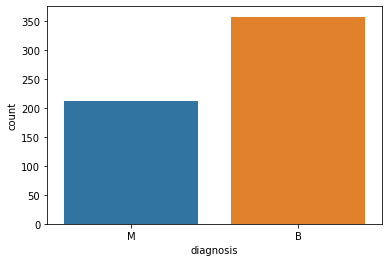

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1) = plt.subplots(ncols=1, figsize=(6, 4))

sns.countplot(x="diagnosis", data=df)

plt.show()

El problema está mas o menos equilibrado, al menos no hay ninguna clase con un % de instancias muy pequeño

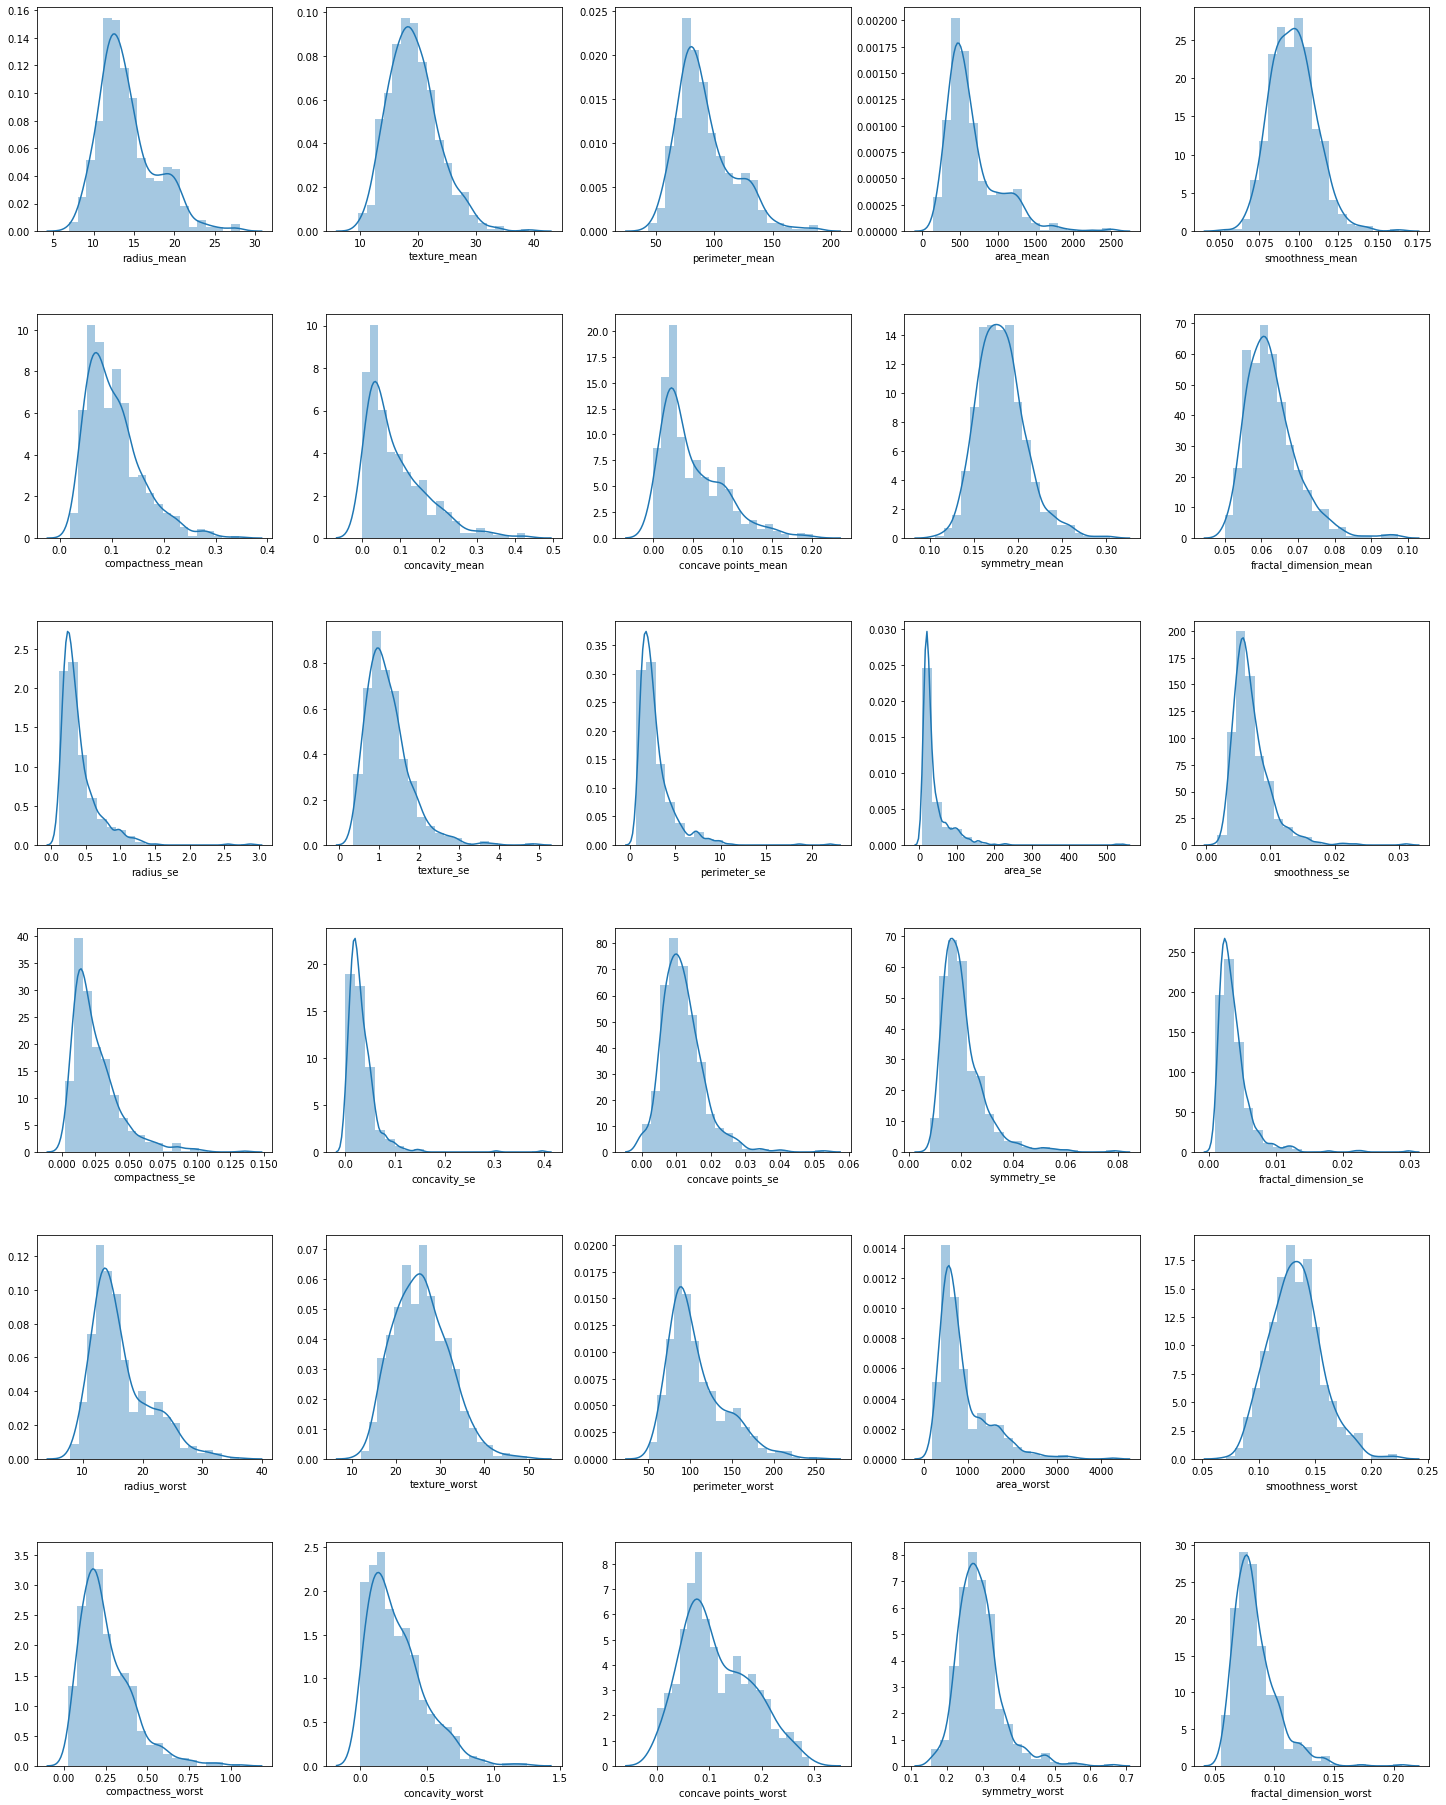

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=5, nrows=6, figsize=(20, 25))
axs = axs.flatten() # 

index = 0
for k,v in df.drop(["diagnosis"], axis="columns").items(): 
    sns.distplot(v, bins=20, ax=axs[index])
    index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### 2.2 - Bivariate analysis


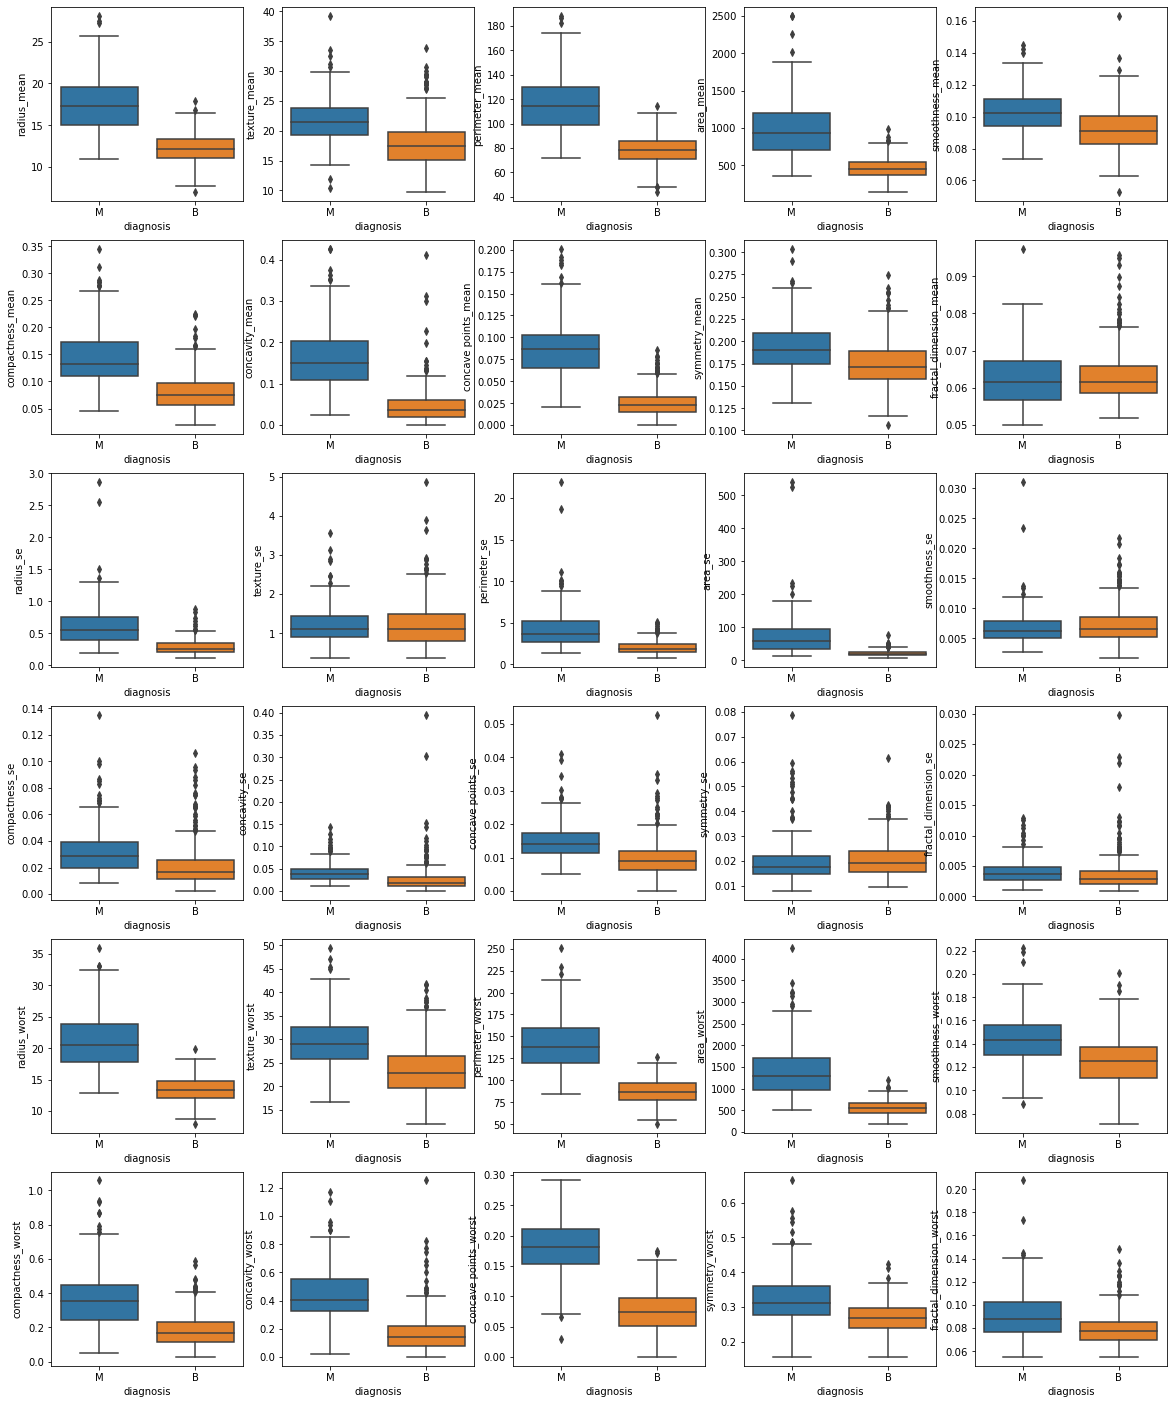

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=5, nrows=6, figsize=(20, 25))
axs = axs.flatten()

index = 0
for colname in df.columns:
    if colname != "diagnosis":
        sns.boxplot(ax=axs[index], x="diagnosis", y=colname, data=df)
        index += 1

Estimo la informacion mútua normalizada entre cada par de variables

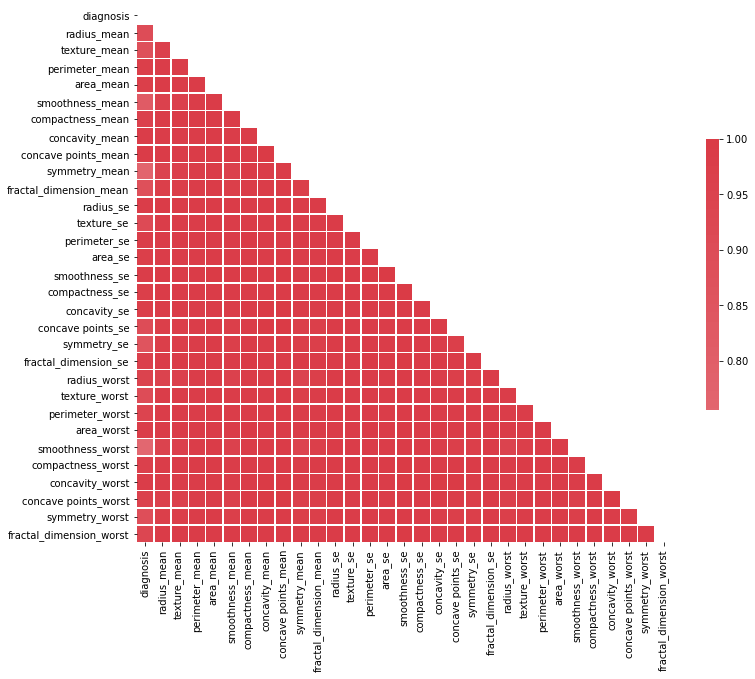

In [57]:
from sklearn.metrics import normalized_mutual_info_score as nmi
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# All variables
nmi_df = pd.DataFrame(columns=df.columns, index=df.columns)

for col_1 in nmi_df.columns:
    for col_2 in nmi_df.columns:
        nmi_df.loc[col_1, col_2] = nmi(df[col_1], df[col_2], average_method="min")

for col in nmi_df.columns:
    nmi_df[col] = pd.to_numeric(nmi_df[col])

for col in nmi_df.columns:
    nmi_df[col] = nmi_df[col].astype("float64")  
    
# Generate a mask for the upper triangle
mask = np.zeros_like(nmi_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(nmi_df, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [70]:
nmi_df["diagnosis"].sort_values(ascending=False)

diagnosis                  1.000000
concave points_mean        0.988931
area_worst                 0.981551
concavity_mean             0.981551
smoothness_se              0.981551
radius_se                  0.980159
perimeter_se               0.977862
concavity_worst            0.976469
area_mean                  0.974172
concavity_se               0.974172
perimeter_mean             0.972779
area_se                    0.971387
compactness_se             0.969090
compactness_worst          0.964007
fractal_dimension_se       0.963103
concave points_worst       0.960318
compactness_mean           0.954331
radius_worst               0.945071
perimeter_worst            0.943262
fractal_dimension_worst    0.935882
texture_se                 0.907269
texture_worst              0.906365
radius_mean                0.903580
concave points_se          0.901282
symmetry_worst             0.887428
fractal_dimension_mean     0.877752
texture_mean               0.877263
symmetry_se                0

He observado la matriz de NMI y nos da valores muy altos, tan altos que no se observa nada relevante. Por ello, y para contrastar, voy a probar a evluar la correlacion entre las variables numericas

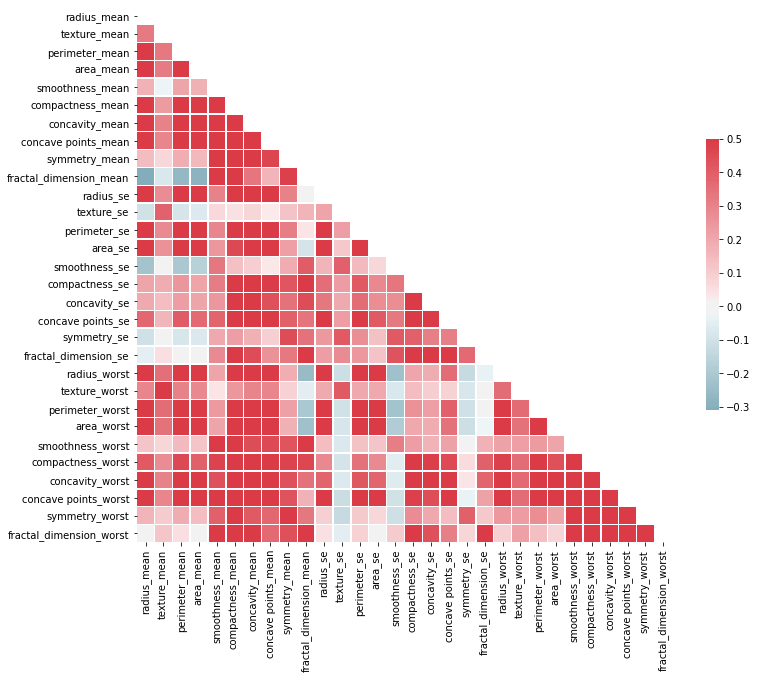

In [60]:
import numpy as np

corr = df.drop(["diagnosis"], axis="columns").corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

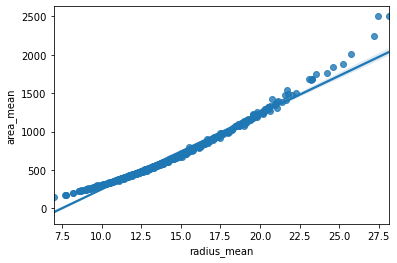

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1) = plt.subplots(ncols=1, figsize=(6, 4))

sns.regplot(x=df["radius_mean"], y=df["area_mean"])

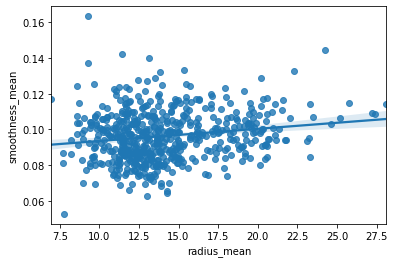

In [69]:
sns.regplot(x=df["radius_mean"], y=df["smoothness_mean"])

Podemos observar claramente que aquellos aspectos que estan relacionados con las dimensiones del nucleo de la celula tienen una relacion practicamente lineal. Por ejemplo, el radio medio de la celula esta relacionado con el area media de la celula. Sin embargo, otros aspectos de la misma como su rugosidad pues no tienen un relacion lineal tan directa

----

Si bien la correlacion parece darnos algo mas de informacion que la NMI, se mantienen el hecho de las features parecen estar muy relacionadas entre si, al menos de forma bivariante (sin condicionar a otras variables)

A simple vista, este podria ser un buen ejemplo para aplicar seleccion de variables (**feature selection**). 

#### Notes on feature selection

There are <a href="https://en.wikipedia.org/wiki/Feature_selection#Main_principles">three main types of feature selection</a> based on how they combine the selection algorithm and the process of model building.

* **Filter approach**. Filter type methods select variables regardless of the model. 
    * They are based only on general features like the correlation or mutual information with the variable to predict.
    * These methods are particularly effective in computation time and robust to overfitting. 
    * These methods tend to select redundant variables when they do not consider the relationships between variables. However, more elaborate features try to minimize this problem by removing variables highly related to each other, such as the mRMR algorithm of Peng et al.(2005).
    * Several well-known filter methods are based on <a href="https://en.wikipedia.org/wiki/Feature_selection#Information_Theory_Based_Feature_Selection_Mechanisms">information theory</a>.
    * Scikit-learn doesn't provide a specific filter method for feature selection, but we could create our own by estimating the MI, NMI or correlation between variables. 

<img src="images/filter_method.png" width="500">

* **Wrapper approach**. Wrapper type methods evaluate subsets of variables with respect to the predictive score.
    * They are usually applied in combination with cross-validation. A common idea is to start with all the feature variables and then recursively prune the subset of least relevant variables.
    * They can be applied with any estimator as long as there is a score to optimize.
    * They are very computationally expensive.
    * There is a higher risk of overfitting, which can be reduced with cross-validation.
    * Scikit-learn provides an implementation for those methods with built-in feature importances such as decision trees and SVMs. See the class <a href="https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV"><code>sklearn.feature_selection.RFECV</code></a>.
    

<img src="images/wrapper_method.png" width="500">

* **Embedded approach**.
    * The search for an optimal subset of features is built into the model construction.
    * They combine the advantages of filter and wrapper approaches, but they are specific to the estimator. The estimator performs feature selection and prediction simultaneously.

<img src="images/embedded_method.png" width="500">

## 3 - Classification

In [71]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["diagnosis"])
Y = df["diagnosis"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

### 3.1 - SVM

##### Linear kernel

In [27]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

svm_linear = SVC(kernel="linear")

scores = cross_val_score(svm_linear, X_train, Y_train, cv=10) # By default we use the R2 score
print("Cross-val score: " + str(scores.mean()))

Cross-val score: 0.9448792270531401


##### RBF kernel

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

svm_rbf = SVC(kernel="rbf")

scores = cross_val_score(svm_rbf, X_train, Y_train, cv=10) # By default we use the R2 score
print("Cross-val score: " + str(scores.mean()))

Cross-val score: 0.9116425120772949


##### Polynomial kernel

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

svm_poly = SVC(kernel="poly", degree=3)

scores = cross_val_score(svm_poly, X_train, Y_train, cv=10) # By default we use the R2 score
print("Cross-val score: " + str(scores.mean()))

Cross-val score: 0.9072463768115944


### 3.2 - Decision tree

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dt_clas = DecisionTreeClassifier(random_state=0)

scores = cross_val_score(dt_clas, X_train, Y_train, cv=10) # By default we use the R2 score
print("Cross-val score: " + str(scores.mean()))

Cross-val score: 0.9053623188405797


### 3.3 - KNN

##### $k = 3$

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn_clas_3 = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn_clas_3, X_train, Y_train, cv=10) # By default we use the R2 score
print("Cross-val score: " + str(scores.mean()))

Cross-val score: 0.9206280193236716


##### $k = 5$

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn_clas_5 = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn_clas_5, X_train, Y_train, cv=10) # By default we use the R2 score
print("Cross-val score: " + str(scores.mean()))

Cross-val score: 0.9206280193236716


##### $k = 11$

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn_clas_11 = KNeighborsClassifier(n_neighbors=11)
scores = cross_val_score(knn_clas_11, X_train, Y_train, cv=10) # By default we use the R2 score
print("Cross-val score: " + str(scores.mean()))

Cross-val score: 0.9249758454106282


### 3.4 - Naïve Bayes

In [36]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

naive_bayes = GaussianNB()
scores = cross_val_score(naive_bayes, X_train, Y_train, cv=10) # By default we use the R2 score
print("Cross-val score: " + str(scores.mean()))

Cross-val score: 0.9316425120772948


## 4 - Estimator evaluation

In [39]:
svm_fitted = svm_linear.fit(X_train, Y_train)
dt_clas_fitted = dt_clas.fit(X_train, Y_train)
knn_clas_fitted = knn_clas_11.fit(X_train, Y_train)
naive_bayes_fitted = naive_bayes.fit(X_train, Y_train)

### 4.1 - Accuracy

In [40]:
print("SVM test score: " + str(svm_fitted.score(X_test, Y_test)))
print("Decision tree test score: " + str(dt_clas_fitted.score(X_test, Y_test)))
print("KNN test score: " + str(knn_clas_fitted.score(X_test, Y_test)))
print("Naive Bayes test score: " + str(naive_bayes_fitted.score(X_test, Y_test)))

SVM test score: 0.9736842105263158
Decision tree test score: 0.9473684210526315
KNN test score: 0.956140350877193
Naive Bayes test score: 0.9473684210526315


### 4.2 - Confusion matrix

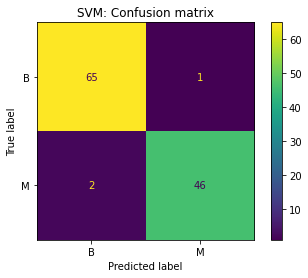

In [44]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(svm_fitted, X_test, Y_test) 
plt.title("SVM: Confusion matrix")
plt.show()

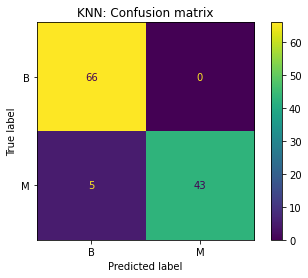

In [46]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(knn_clas_fitted, X_test, Y_test) 
plt.title("KNN: Confusion matrix")
plt.show()

### 4.3 - Precision and recall
TP: True posities
TN: True negatives

<img src="images/precision_recall_3.png" width="300">

In [49]:
knn_predictions = knn_clas_fitted.predict(X_test)
knn_predictions

array(['M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'M', 'M', 'B', 'M', 'M', 'M', 'B', 'M', 'B', 'B', 'M', 'B', 'B',
       'M', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'M', 'B', 'M', 'B', 'B',
       'B', 'B', 'B', 'M', 'M', 'M', 'B', 'M', 'M', 'M', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B',
       'M', 'M', 'M', 'B', 'M', 'M', 'M', 'B', 'M', 'B', 'M', 'M', 'M',
       'M', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B',
       'M', 'M', 'B', 'M', 'B', 'M', 'B', 'M', 'B', 'M'], dtype=object)

In [51]:
svm_predictions = svm_fitted.predict(X_test)
svm_predictions

array(['M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B',
       'M', 'M', 'B', 'M', 'M', 'M', 'B', 'M', 'B', 'B', 'M', 'B', 'B',
       'M', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'M', 'B', 'M', 'B', 'B',
       'B', 'B', 'B', 'M', 'M', 'M', 'B', 'M', 'M', 'M', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'B',
       'M', 'M', 'M', 'B', 'M', 'M', 'M', 'B', 'M', 'B', 'M', 'M', 'M',
       'M', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B',
       'M', 'M', 'M', 'M', 'B', 'M', 'B', 'M', 'M', 'M'], dtype=object)

A ojo veo que hay una instancia (la penultima) que las clasifican diferente y que deberia ser clasificada como maligno (M) pero que el clasificador KNN ha clasificado como benigno (B).

In [56]:
from sklearn.metrics import classification_report

print("SVM evaluation")
print(classification_report(Y_test, svm_predictions, labels=["B", "M"]))

print("\nKNN evaluation")
print(classification_report(Y_test, knn_predictions, labels=["B", "M"]))

SVM evaluation
              precision    recall  f1-score   support

           B       0.97      0.98      0.98        66
           M       0.98      0.96      0.97        48

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


KNN evaluation
              precision    recall  f1-score   support

           B       0.93      1.00      0.96        66
           M       1.00      0.90      0.95        48

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



## References

#### Links
1. <a href="https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/">ROC vs Precision-recall curves</a>